In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics.cluster import silhouette_score
import pickle
import catboost as cbt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import numpy as np

c:\users\eugene\appdata\local\programs\python\python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
# # Shuffle the Dataset.
# shuffled_df = train_df.sample(frac=1, random_state=42)

# # Put all the fraud class in a separate dataset.
# fraud_df = shuffled_df.loc[shuffled_df['is_churn'] == 1]

# #Randomly select 2 observations from the non-fraud (majority class)
# non_fraud_df = shuffled_df.loc[shuffled_df['is_churn'] == 0].sample(n=len(fraud_df), random_state=42)

# # Concatenate both dataframes again
# train_df = pd.concat([fraud_df, non_fraud_df])
# train_df.reset_index(drop=True, inplace=True)

In [4]:
train_df.head(5)

,TENURE,CITY,is_churn,BILLS_NUM,INV_MON_1,INV_MON_2,INV_MON_3,INV_MON_4,INV_MON_5,INV_MON_6,...,ADJ_TYP_CREDIT_BALANCE,ADJ_TYP_PAYMENT_DEBIT_AUTHORIZ,ADJ_TYP_PAY_PER_VIEW,ADJ_TYP_RECONNECT_FEES,CUSTOMER_ID,PAYMENT_METHOD,AGE,LANGUAGE,GENDER,REGION
0,31,0,0,6,103870,150900,150900,150900,150900,148360,...,0,0,0,0,385655,Other,27.0,first_language,UNKNOWN,0
1,429,362,0,6,123090,152930,152930,152930,152930,152930,...,0,0,0,0,446885,Other,65.0,first_language,UNKNOWN,0
2,97,102,0,6,121680,116130,116280,115980,120330,120180,...,0,0,0,0,537638,Pre-authorized_Debit,85.0,first_language,UNKNOWN,0
3,50,41,0,6,128700,124860,122550,115940,156850,151600,...,0,0,0,0,140284,Other,35.0,first_language,UNKNOWN,0
4,396,195,0,6,155790,133940,133940,138940,141920,133940,...,0,0,0,0,700911,Pre-authorized_Debit,61.0,first_language,UNKNOWN,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589878 entries, 0 to 589877
Columns: 166 entries, TENURE to REGION
dtypes: float64(74), int64(89), object(3)
memory usage: 747.1+ MB


In [6]:
train_df.describe()

,TENURE,CITY,is_churn,BILLS_NUM,INV_MON_1,INV_MON_2,INV_MON_3,INV_MON_4,INV_MON_5,INV_MON_6,...,ADJ_TYP_ACTIVATION_FEES,ADJ_TYP_REFUSED_BY_PAYOR_OTHER,ADJ_TYP_RATE_CHANGE,ADJ_TYP_CREDIT_BALANCE,ADJ_TYP_PAYMENT_DEBIT_AUTHORIZ,ADJ_TYP_PAY_PER_VIEW,ADJ_TYP_RECONNECT_FEES,CUSTOMER_ID,AGE,REGION
count,589878.000000,589878.000000,589878.000000,589878.000000,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,...,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.00000,589878.000000,544680.000000,589878.000000
mean,135.570031,219.041926,0.014105,5.845393,1.168338e+05,1.156493e+05,1.143315e+05,1.129201e+05,1.121481e+05,1.122137e+05,...,0.000702,0.000385,0.001721,0.000049,0.000215,0.000149,0.00009,393230.227766,57.082373,0.511692
std,125.846114,135.310829,0.117922,0.833427,8.139013e+04,7.100998e+04,7.265393e+04,7.092877e+04,6.991717e+04,7.028929e+04,...,0.031672,0.021112,0.071425,0.007011,0.019529,0.023724,0.00983,227011.459651,16.595199,1.182091
min,0.000000,0.000000,0.000000,1.000000,-1.681080e+06,-2.381200e+06,-2.029880e+06,-4.892540e+06,-1.922680e+06,-3.789060e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.000000,19.000000,0.000000
25%,30.000000,105.000000,0.000000,6.000000,7.398000e+04,7.299000e+04,7.289000e+04,7.119000e+04,6.999000e+04,6.899000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,196534.250000,45.000000,0.000000
50%,93.000000,202.000000,0.000000,6.000000,1.119300e+05,1.113800e+05,1.109200e+05,1.099500e+05,1.089900e+05,1.092900e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,393363.500000,58.000000,0.000000
75%,213.000000,367.000000,0.000000,6.000000,1.528900e+05,1.528900e+05,1.526275e+05,1.510200e+05,1.509300e+05,1.518900e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,589706.750000,70.000000,1.000000
max,578.000000,428.000000,1.000000,16.000000,2.837117e+07,9.669700e+06,1.040979e+07,1.138197e+07,6.996450e+06,4.223170e+06,...,5.000000,3.000000,6.000000,1.000000,8.000000,16.000000,2.00000,786503.000000,93.000000,9.000000


In [7]:
columns = list(train_df.columns)
print(columns)

['TENURE', 'CITY', 'is_churn', 'BILLS_NUM', 'INV_MON_1', 'INV_MON_2', 'INV_MON_3', 'INV_MON_4', 'INV_MON_5', 'INV_MON_6', 'N_LATE_FEES', 'N_NON_SETTLED', 'AVG_BILL', 'MIN_BILL', 'MAX_BILL', 'MAX2MIN_BILL', 'PAY_NUM', 'AVG_PAY', 'MAX_PAY', 'MIN_PAY', 'PAY_MON_1', 'PAY_MON_2', 'PAY_MON_3', 'PAY_MON_4', 'PAY_MON_5', 'PAY_MON_6', 'MAX2MIN_PAY', 'ADJ_NUM', 'AVG_ADJ', 'ADJ_MON_1', 'ADJ_MON_2', 'ADJ_MON_3', 'ADJ_MON_4', 'ADJ_MON_5', 'ADJ_MON_6', 'MIN_ADJ', 'MAX_ADJ', 'MAXMINDIFF_ADJ', 'DSON_NUM_BUNDLE', 'DSON_MON_1_BUNDLE', 'DSON_MON_2_BUNDLE', 'DSON_MON_3_BUNDLE', 'DSON_MON_4_BUNDLE', 'DSON_MON_5_BUNDLE', 'DSON_MON_6_BUNDLE', 'DSON_NUM_PROMO', 'DSON_MON_1_PROMO', 'DSON_MON_2_PROMO', 'DSON_MON_3_PROMO', 'DSON_MON_4_PROMO', 'DSON_MON_5_PROMO', 'DSON_MON_6_PROMO', 'DSOF_NUM_BUNDLE', 'DSOF_MON_1_BUNDLE', 'DSOF_MON_2_BUNDLE', 'DSOF_MON_3_BUNDLE', 'DSOF_MON_4_BUNDLE', 'DSOF_MON_5_BUNDLE', 'DSOF_MON_6_BUNDLE', 'DSOF_NUM_PROMO', 'DSOF_MON_1_PROMO', 'DSOF_MON_2_PROMO', 'DSOF_MON_3_PROMO', 'DSOF_MON_4

In [8]:
train_y = train_df['is_churn'].copy()
train_x = train_df.drop('is_churn', axis=1)

In [9]:
train_x["AGE"] = train_x["AGE"].fillna(train_x["AGE"].mean())
train_x.drop('CUSTOMER_ID', axis=1, inplace=True)
# train_x.drop('CITY', axis=1, inplace=True)
t_col = ['PAYMENT_METHOD', 'LANGUAGE', 'GENDER']
ore = OrdinalEncoder()
ore.fit(train_x[t_col])
train_x[t_col] = ore.transform(train_x[t_col])
train_x.head(5)

,TENURE,CITY,BILLS_NUM,INV_MON_1,INV_MON_2,INV_MON_3,INV_MON_4,INV_MON_5,INV_MON_6,N_LATE_FEES,...,ADJ_TYP_RATE_CHANGE,ADJ_TYP_CREDIT_BALANCE,ADJ_TYP_PAYMENT_DEBIT_AUTHORIZ,ADJ_TYP_PAY_PER_VIEW,ADJ_TYP_RECONNECT_FEES,PAYMENT_METHOD,AGE,LANGUAGE,GENDER,REGION
0,31,0,6,103870,150900,150900,150900,150900,148360,0,...,0,0,0,0,0,0.0,27.0,0.0,2.0,0
1,429,362,6,123090,152930,152930,152930,152930,152930,0,...,0,0,0,0,0,0.0,65.0,0.0,2.0,0
2,97,102,6,121680,116130,116280,115980,120330,120180,0,...,0,0,0,0,0,2.0,85.0,0.0,2.0,0
3,50,41,6,128700,124860,122550,115940,156850,151600,3,...,0,0,0,0,0,0.0,35.0,0.0,2.0,0
4,396,195,6,155790,133940,133940,138940,141920,133940,0,...,0,0,0,0,0,2.0,61.0,0.0,2.0,0


In [10]:
ohe_columns = ['CITY', 'TFT', 'SUPPORT', 'SOCIAL_MEDIA', 'OUTBOUND_CALL', 'MANAGE_ACCT', 'INQUIRY', 'INBOUND_CALL', 'ESCALATION', 'EMAIL', 'CALL_BACK', 'CTI', 'PLAY_TV', 'PLAY_PHONE', 'PLAY_INET', 'SINGLE_PLAY', 'DOUBLE_PLAY', 'TRIPLE_PLAY', 'UNKNOWN_PLAY', 'ITR_CAT_119', 'ITR_CAT_120', 'ITR_CAT_114', 'ITR_CAT_9', 'ITR_CAT_123', 'ITR_CAT_128', 'ITR_CAT_102', 'ITR_CAT_104', 'ITR_CAT_115', 'ITR_CAT_8', 'ITR_CAT_122', 'ITR_CAT_0', 'ITR_CAT_22', 'ITR_CAT_133', 'ITR_CAT_124', 'ITR_CAT_135', 'ITR_CAT_56', 'ITR_CAT_113', 'ITR_CAT_126', 'ITR_CAT_116', 'ITR_CAT_84', 'ITR_CAT_51', 'ITR_CAT_117', 'ITR_CAT_105', 'ITR_CAT_81', 'ITR_CAT_54', 'ITR_CAT_101', 'ITR_CAT_134', 'ITR_CAT_71', 'ITR_CAT_62', 'ITR_CAT_78', 'ITR_CAT_138', 'ITR_CAT_17', 'ITR_CAT_41', 'ITR_CAT_69', 'ADJ_TYP_BALANCE_TRANSFER', 'ADJ_TYP_CREDIT_UNRETURNED_EQUI', 'ADJ_TYP_TELEVISION_PRODUCT', 'ADJ_TYP_OTHERS', 'ADJ_TYP_COLLECTION_CHARGES', 'ADJ_TYP_GOODWILL_CREDIT', 'ADJ_TYP_EQUIPMENT', 'ADJ_TYP_INTERNET_USAGE', 'ADJ_TYP_INSTALLATION_FEES', 'ADJ_TYP_PHONE_PRODUCT', 'ADJ_TYP_TELEPHONY_USAGE', 'ADJ_TYP_EARLY_TERMINATION_FEES', 'ADJ_TYP_VIDEO_ON_DEMAND', 'ADJ_TYP_OTHER_PAYMENTS', 'ADJ_TYP_RECOVERY_OF_CREDIT_WRI', 'ADJ_TYP_LATE_FEES', 'ADJ_TYP_ADMIN_FEES', 'ADJ_TYP_OTHER_FEES', 'ADJ_TYP_INTERNET_PRODUCT', 'ADJ_TYP_ACTIVATION_FEES', 'ADJ_TYP_REFUSED_BY_PAYOR_OTHER', 'ADJ_TYP_RATE_CHANGE', 'ADJ_TYP_CREDIT_BALANCE', 'ADJ_TYP_PAYMENT_DEBIT_AUTHORIZ', 'ADJ_TYP_PAY_PER_VIEW', 'ADJ_TYP_RECONNECT_FEES', 'PAYMENT_METHOD', 'LANGUAGE', 'GENDER', 'REGION']
scaler_columns = ['TENURE', 'BILLS_NUM', 'INV_MON_1', 'INV_MON_2', 'INV_MON_3', 'INV_MON_4', 'INV_MON_5', 'INV_MON_6', 'N_LATE_FEES', 'N_NON_SETTLED', 'AVG_BILL', 'MIN_BILL', 'MAX_BILL', 'MAX2MIN_BILL', 'PAY_NUM', 'AVG_PAY', 'MAX_PAY', 'MIN_PAY', 'PAY_MON_1', 'PAY_MON_2', 'PAY_MON_3', 'PAY_MON_4', 'PAY_MON_5', 'PAY_MON_6', 'MAX2MIN_PAY', 'ADJ_NUM', 'AVG_ADJ', 'ADJ_MON_1', 'ADJ_MON_2', 'ADJ_MON_3', 'ADJ_MON_4', 'ADJ_MON_5', 'ADJ_MON_6', 'MIN_ADJ', 'MAX_ADJ', 'MAXMINDIFF_ADJ', 'DSON_NUM_BUNDLE', 'DSON_MON_1_BUNDLE', 'DSON_MON_2_BUNDLE', 'DSON_MON_3_BUNDLE', 'DSON_MON_4_BUNDLE', 'DSON_MON_5_BUNDLE', 'DSON_MON_6_BUNDLE', 'DSON_NUM_PROMO', 'DSON_MON_1_PROMO', 'DSON_MON_2_PROMO', 'DSON_MON_3_PROMO', 'DSON_MON_4_PROMO', 'DSON_MON_5_PROMO', 'DSON_MON_6_PROMO', 'DSOF_NUM_BUNDLE', 'DSOF_MON_1_BUNDLE', 'DSOF_MON_2_BUNDLE', 'DSOF_MON_3_BUNDLE', 'DSOF_MON_4_BUNDLE', 'DSOF_MON_5_BUNDLE', 'DSOF_MON_6_BUNDLE', 'DSOF_NUM_PROMO', 'DSOF_MON_1_PROMO', 'DSOF_MON_2_PROMO', 'DSOF_MON_3_PROMO', 'DSOF_MON_4_PROMO', 'DSOF_MON_5_PROMO', 'DSOF_MON_6_PROMO', 'INTERACTS_NUM', 'INV_MON_A', 'INV_MON_B', 'PAY_MON_A', 'PAY_MON_B', 'ADJ_MON_A', 'ADJ_MON_B', 'DSON_MONPROMO_A', 'DSON_MONPROMO_B', 'DSOF_MONPROMO_A', 'DSOF_MONPROMO_B', 'DSON_MONBUNDLE_A', 'DSON_MONBUNDLE_B', 'DSOF_MONBUNDLE_A', 'DSOF_MONBUNDLE_B', 'AGE']

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
train_x[scaler_columns] = scaler.fit_transform(train_x[scaler_columns])
train_x.head(5)

,TENURE,CITY,BILLS_NUM,INV_MON_1,INV_MON_2,INV_MON_3,INV_MON_4,INV_MON_5,INV_MON_6,N_LATE_FEES,...,ADJ_TYP_RATE_CHANGE,ADJ_TYP_CREDIT_BALANCE,ADJ_TYP_PAYMENT_DEBIT_AUTHORIZ,ADJ_TYP_PAY_PER_VIEW,ADJ_TYP_RECONNECT_FEES,PAYMENT_METHOD,AGE,LANGUAGE,GENDER,REGION
0,0.053633,0,0.333333,0.059395,0.210117,0.175309,0.309898,0.232487,0.491426,0.000,...,0,0,0,0,0,0.0,0.108108,0.0,2.0,0
1,0.742215,362,0.333333,0.060034,0.210286,0.175472,0.310023,0.232714,0.491997,0.000,...,0,0,0,0,0,0.0,0.621622,0.0,2.0,0
2,0.167820,102,0.333333,0.059988,0.207232,0.172525,0.307752,0.229059,0.487909,0.000,...,0,0,0,0,0,2.0,0.891892,0.0,2.0,0
3,0.086505,41,0.333333,0.060221,0.207956,0.173030,0.307750,0.233154,0.491831,0.375,...,0,0,0,0,0,0.0,0.216216,0.0,2.0,0
4,0.685121,195,0.333333,0.061123,0.208710,0.173945,0.309163,0.231480,0.489626,0.000,...,0,0,0,0,0,2.0,0.567568,0.0,2.0,0


In [12]:
ohe = OneHotEncoder(handle_unknown='ignore')
# ohe.fit(train_x[ohe_columns])
# enc_df = pd.DataFrame(ohe.transform(train_x[ohe_columns]).toarray())
train_x = train_x.join(pd.DataFrame(ohe.fit_transform(train_x[ohe_columns]).toarray()))
train_x.drop(columns=ohe_columns, axis=1, inplace=True)
train_x.head(5)

,TENURE,BILLS_NUM,INV_MON_1,INV_MON_2,INV_MON_3,INV_MON_4,INV_MON_5,INV_MON_6,N_LATE_FEES,N_NON_SETTLED,...,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293
0,0.053633,0.333333,0.059395,0.210117,0.175309,0.309898,0.232487,0.491426,0.000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.742215,0.333333,0.060034,0.210286,0.175472,0.310023,0.232714,0.491997,0.000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.167820,0.333333,0.059988,0.207232,0.172525,0.307752,0.229059,0.487909,0.000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.086505,0.333333,0.060221,0.207956,0.173030,0.307750,0.233154,0.491831,0.375,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.685121,0.333333,0.061123,0.208710,0.173945,0.309163,0.231480,0.489626,0.000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
pca = PCA(n_components=0.95)
pca.fit(train_x)
pcax = pca.transform(train_x)
pcax.shape

c:\users\eugene\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\users\eugene\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


(589878, 189)

In [14]:
with open('pca.pkl', 'wb') as f:
    spkl = pickle.dump(pcax, f)

In [15]:
train_pcax = pd.DataFrame(pcax)
train_pcax.to_csv('pca_train.csv', index=False)
train_pcax.head(5)

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,188
0,-1.201052,-0.242211,1.106286,0.173531,-0.145327,0.451454,0.019492,0.114680,0.042651,-0.722272,...,0.025134,0.009050,0.004151,-0.007065,-0.002629,0.001878,-0.010764,-0.009093,-0.000151,0.030153
1,-0.261405,1.720651,-0.212103,-0.504645,-0.015213,0.230024,-0.005537,0.005175,0.152903,-0.476360,...,0.024621,-0.011205,-0.000631,0.036437,-0.007931,0.004924,-0.028909,-0.005551,0.011267,0.014611
2,-0.697357,0.053366,0.877235,0.792344,1.492593,0.455981,-0.392858,0.149068,-0.045097,0.001418,...,-0.061988,-0.009149,0.054675,0.021902,-0.009317,-0.030141,0.026671,0.000786,0.006489,-0.040113
3,-0.918002,-0.570424,1.021631,-0.783044,-0.258960,-0.455489,-0.416974,-0.056089,0.074055,-0.139242,...,0.001912,0.006177,0.001270,0.000546,-0.004959,0.006769,-0.012685,-0.000028,0.000850,-0.000180
4,-0.771035,0.016783,0.965997,0.759482,0.952478,-0.003124,0.573689,-0.355936,0.579252,-0.278783,...,0.004613,-0.004009,-0.000183,0.006908,0.001030,-0.003004,-0.001451,-0.000079,0.002882,0.004757


In [16]:
cbt_clf = cbt.CatBoostClassifier(eval_metric='AUC', custom_metric='AUC:hints=skip_train~false')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train_pcax, train_y, test_size=0.2, stratify=train_y)

In [18]:
cbt_clf.fit(X_train, y_train)

Learning rate set to 0.14278
0:	learn: 0.6658568	total: 358ms	remaining: 5m 58s
1:	learn: 0.6929201	total: 544ms	remaining: 4m 31s
2:	learn: 0.7717477	total: 798ms	remaining: 4m 25s
3:	learn: 0.7809673	total: 969ms	remaining: 4m 1s
4:	learn: 0.8191654	total: 1.18s	remaining: 3m 53s
5:	learn: 0.8325096	total: 1.38s	remaining: 3m 48s
6:	learn: 0.8566189	total: 1.57s	remaining: 3m 43s
7:	learn: 0.8672107	total: 1.76s	remaining: 3m 37s
8:	learn: 0.8761178	total: 1.96s	remaining: 3m 35s
9:	learn: 0.8762692	total: 2.15s	remaining: 3m 32s
10:	learn: 0.8789300	total: 2.33s	remaining: 3m 29s
11:	learn: 0.8858921	total: 2.53s	remaining: 3m 28s
12:	learn: 0.8871631	total: 2.77s	remaining: 3m 30s
13:	learn: 0.8902267	total: 3s	remaining: 3m 31s
14:	learn: 0.8995100	total: 3.22s	remaining: 3m 31s
15:	learn: 0.9032952	total: 3.39s	remaining: 3m 28s
16:	learn: 0.9097775	total: 3.58s	remaining: 3m 27s
17:	learn: 0.9120490	total: 3.83s	remaining: 3m 28s
18:	learn: 0.9159332	total: 4.07s	remaining: 3m 3

c:\users\eugene\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


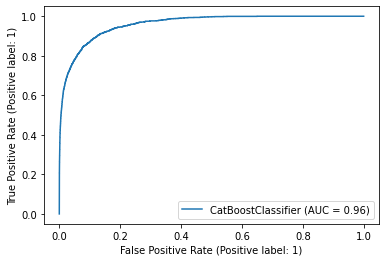

In [19]:
plot_roc_curve(cbt_clf,X_test,y_test)

In [20]:
roc_auc_score(y_test, cbt_clf.predict_proba(X_test)[:,1])

0.9597955480402179

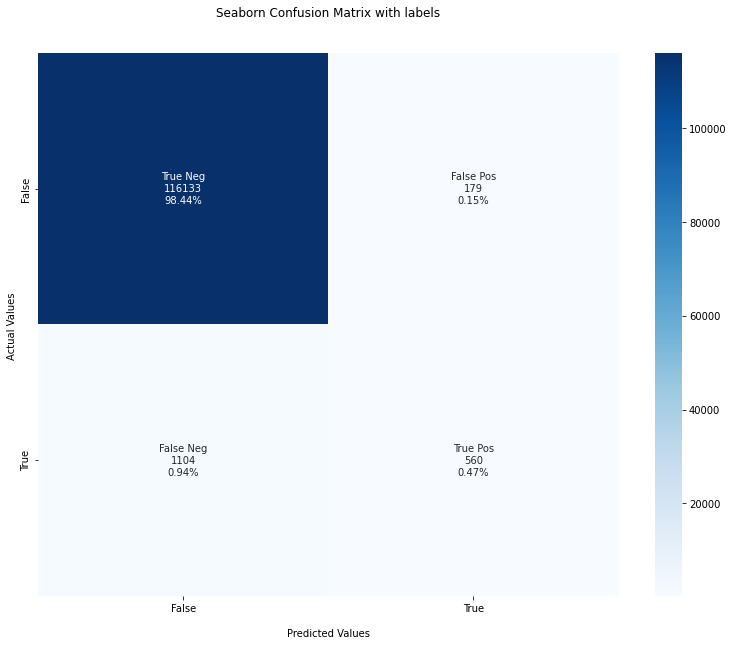

In [22]:
import seaborn as sns
plt.figure(figsize=(13, 10))
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix = confusion_matrix(y_test,cbt_clf.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

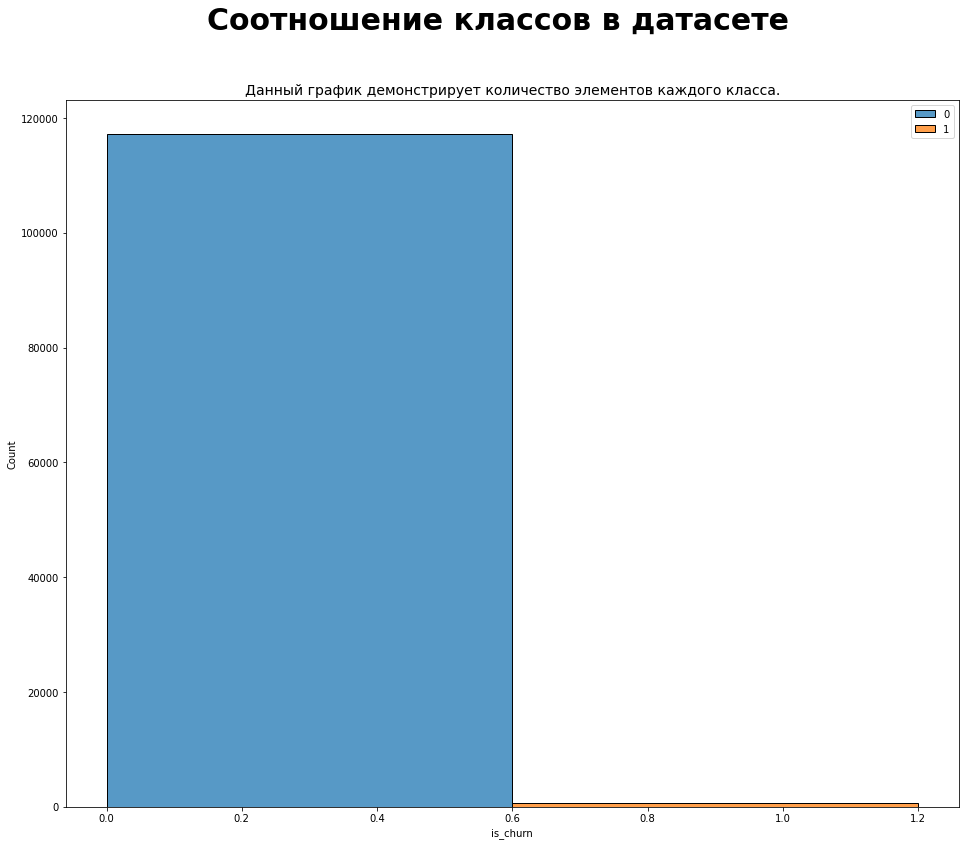

In [23]:
fig = plt.figure(figsize=(16,13))
sas = sns.histplot(x=y_test, hue=cbt_clf.predict(X_test),multiple="dodge",binwidth=1.2)
fig.suptitle("Соотношение классов в датасете", size = 30, fontweight = 'bold')
plt.title('Данный график демонстрирует количество элементов каждого класса.', fontsize=14)
plt.show()

In [24]:
cbt_clf.fit(train_pcax, train_y)

Learning rate set to 0.157054
0:	learn: 0.6688735	total: 242ms	remaining: 4m 2s
1:	learn: 0.6947856	total: 458ms	remaining: 3m 48s
2:	learn: 0.7840668	total: 752ms	remaining: 4m 9s
3:	learn: 0.7975074	total: 1.02s	remaining: 4m 14s
4:	learn: 0.8377304	total: 1.24s	remaining: 4m 7s
5:	learn: 0.8469453	total: 1.46s	remaining: 4m 1s
6:	learn: 0.8660202	total: 1.69s	remaining: 3m 59s
7:	learn: 0.8660272	total: 1.88s	remaining: 3m 53s
8:	learn: 0.8709068	total: 2.12s	remaining: 3m 53s
9:	learn: 0.8736343	total: 2.37s	remaining: 3m 54s
10:	learn: 0.8877577	total: 2.61s	remaining: 3m 54s
11:	learn: 0.8913028	total: 2.88s	remaining: 3m 56s
12:	learn: 0.8923919	total: 3.1s	remaining: 3m 55s
13:	learn: 0.9002571	total: 3.3s	remaining: 3m 52s
14:	learn: 0.9018540	total: 3.55s	remaining: 3m 53s
15:	learn: 0.9044265	total: 3.79s	remaining: 3m 53s
16:	learn: 0.9067477	total: 4.05s	remaining: 3m 54s
17:	learn: 0.9094585	total: 4.29s	remaining: 3m 53s
18:	learn: 0.9172231	total: 4.5s	remaining: 3m 52s

In [25]:
test_data = pd.read_csv('test.csv')
test_df = test_data.copy()
test_df["AGE"] = test_df["AGE"].fillna(test_df["AGE"].mean())
test_df.drop('CUSTOMER_ID', axis=1, inplace=True)
test_df[t_col] = ore.transform(test_df[t_col])
test_df[scaler_columns] = scaler.transform(test_df[scaler_columns])
test_df = test_df.join(pd.DataFrame(ohe.transform(test_df[ohe_columns]).toarray()))
test_df.drop(columns=ohe_columns, axis=1, inplace=True)
pcatest = pca.transform(test_df)
test_pcax = pd.DataFrame(pcatest)
test_pcax.to_csv('pca_test.csv', index=False)
print(test_pcax.shape)
test_pcax.head(5)

c:\users\eugene\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


(196627, 189)


,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,188
0,-1.538519,0.015919,1.287958,1.199601,-0.633594,0.172729,-0.417750,-0.227898,-0.051211,-0.011604,...,0.180012,-0.070114,-0.036192,-0.065836,-0.098451,-0.028153,-0.086315,-0.002158,-0.072949,0.662958
1,0.186044,1.246133,-0.007958,0.935761,0.340161,-0.638822,-1.028112,0.138845,0.460033,0.047338,...,0.025360,-0.021014,-0.008392,-0.004120,-0.002124,-0.002876,-0.011203,0.002704,0.004031,0.010145
2,-0.948592,-0.752364,-1.183245,-0.563589,0.182140,0.417698,-0.335748,0.111939,-0.205992,-0.189568,...,0.002854,-0.013748,0.003722,0.009240,0.004272,0.005974,-0.004756,0.004036,-0.011707,0.007361
3,-0.241742,1.415897,-0.269414,-0.956902,-0.083070,0.005821,0.194771,-0.144547,0.051277,-0.216597,...,-0.011237,-0.095282,-0.071613,0.677815,0.135287,-0.045303,-0.085232,0.086726,-0.034996,0.009963
4,-0.235181,1.251239,-0.079595,0.534865,0.654481,-0.906878,-1.020016,0.095750,0.111354,-0.130310,...,-0.012601,0.008572,0.002708,-0.020249,0.009007,-0.000597,0.016367,-0.001623,0.000236,-0.010996


In [26]:
is_churn = cbt_clf.predict(test_pcax)
is_churn_proba = cbt_clf.predict_proba(test_pcax)[:,1]
print(is_churn)
print(is_churn_proba)

[0 0 0 ... 0 0 0]
[7.35591238e-03 6.87006470e-04 7.21316404e-03 ... 3.06076611e-03
 8.11817785e-06 5.45383707e-06]


In [27]:
test_data['is_churn'] = is_churn
test_data['is_churn_proba'] = is_churn_proba
test_data.head(5)

,TENURE,CITY,BILLS_NUM,INV_MON_1,INV_MON_2,INV_MON_3,INV_MON_4,INV_MON_5,INV_MON_6,N_LATE_FEES,...,ADJ_TYP_PAY_PER_VIEW,ADJ_TYP_RECONNECT_FEES,CUSTOMER_ID,PAYMENT_METHOD,AGE,LANGUAGE,GENDER,REGION,is_churn,is_churn_proba
0,220,25,6,80000,73160,80990,80990,80990,80990,0,...,0,0,445171,Other,80.0,first_language,UNKNOWN,0,0,0.007356
1,379,239,6,240880,160880,160880,160880,160880,139620,0,...,0,0,652721,Pre-authorized_Debit,70.0,first_language,FEMALE,0,0,0.000687
2,120,41,6,93940,107840,86990,107840,93940,80010,0,...,0,0,288131,Other,52.0,first_language,UNKNOWN,0,0,0.007213
3,6,362,6,85990,85990,85990,18200,146450,83990,0,...,0,0,32084,Other,29.0,first_language,UNKNOWN,0,0,0.024722
4,43,120,6,139870,141850,139870,139870,147580,169870,0,...,0,0,313460,Pre-authorized_Debit,78.0,first_language,UNKNOWN,0,0,0.000130


In [30]:
set(test_data['is_churn'])

{0, 1}

In [31]:
set(test_data['is_churn_proba'])

{0.6193714362968876,
 3.7692007026636974e-05,
 0.0023284888648049703,
 0.0058149464664438745,
 0.002189820946796321,
 3.142884702356679e-05,
 0.0005156839245046371,
 0.002793371618054162,
 0.007371029030082364,
 0.005593387671297034,
 0.0015228640479563293,
 4.5209243808142234e-05,
 0.007768467154164692,
 0.005329108372961867,
 0.002408072610023748,
 0.002114303053758718,
 3.236987026868166e-05,
 0.001308832984022972,
 3.2855705967467e-05,
 0.0009527315371542692,
 1.8312741303837315e-05,
 0.00024548343776589136,
 0.0670953621959143,
 0.0004708897595265001,
 0.07358487793703719,
 0.0033071095542709663,
 0.006446310816954822,
 8.060039840532529e-05,
 0.00299502649227182,
 0.0009403654346442948,
 0.00043311630133760905,
 0.036006575038300105,
 0.0038423133325978034,
 0.007310620955195228,
 0.001595355983454322,
 1.1508541092592274e-05,
 0.0003187788183823112,
 0.0010006875911586115,
 0.0003236389818539914,
 3.2756609016826393e-06,
 0.0033746104957117964,
 0.0014685218111481434,
 0.0001994

In [33]:
test_data.loc[test_data['is_churn'] == 1]

,TENURE,CITY,BILLS_NUM,INV_MON_1,INV_MON_2,INV_MON_3,INV_MON_4,INV_MON_5,INV_MON_6,N_LATE_FEES,...,ADJ_TYP_PAY_PER_VIEW,ADJ_TYP_RECONNECT_FEES,CUSTOMER_ID,PAYMENT_METHOD,AGE,LANGUAGE,GENDER,REGION,is_churn,is_churn_proba
137,187,292,6,113780,129870,114480,106230,110430,112920,0,...,0,0,729092,Other,56.0,second_language,FEMALE,1,1,0.812230
222,176,299,6,105930,105930,105930,79930,79930,79930,0,...,0,0,695708,Other,69.0,second_language,FEMALE,1,1,0.799573
589,95,183,5,89290,74490,88990,88990,232750,0,0,...,0,0,577482,Other,63.0,first_language,UNKNOWN,0,1,0.595020
615,5,378,6,35990,35990,35990,35990,35990,63590,0,...,0,0,208290,Other,56.0,first_language,UNKNOWN,0,1,0.790313
1100,13,198,7,115900,118220,100900,100900,100900,84650,1,...,0,0,342525,Other,43.0,second_language,FEMALE,1,1,0.687364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195358,5,398,5,46950,46950,46950,47870,125540,0,0,...,0,0,648725,Other,24.0,second_language,FEMALE,1,1,0.567239
195498,10,422,6,98950,98950,98950,98950,98950,56420,0,...,0,0,506396,Other,31.0,first_language,UNKNOWN,0,1,0.766562
195839,51,74,7,1174270,150330,150130,149980,148930,139080,0,...,0,0,124190,Other,54.0,first_language,UNKNOWN,0,1,0.948272
196078,12,223,7,203580,152650,141780,152160,-59870,141650,4,...,0,0,452449,Other,32.0,first_language,UNKNOWN,0,1,0.834191


In [32]:
test_data.to_csv('test_g2.csv', index=False)